# Turing Deinterleaving Challenge dataset walkthrough

Please ensure all dependencies are installed correctly, a guide for how to do this can be found in README.md
```bash
pip list
```
should display ```turing-deinterleaving-challenge 0.1.0```

## 1. Imports

* ` 
Deinterleaver` an abstract base class that your model **must comply with for evaluation.**
* ```DeinterleavingchallengeDataset``` This class handles our radar pulse data. It handles loading and processing our data, supporting both **full length** pulse trains and **windowed sampling** through the ```window_length``` method. We can also filter/**control the number of emitters** in the dataset using the ```min_emitter, max_emitter``` methods

In [7]:
from pathlib import Path

import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from turing_deinterleaving_challenge import (
    Deinterleaver,
    DeinterleavingChallengeDataset,
    PulseTrain,
    download_dataset,
    evaluate_model_on_dataset,
    plot_pulse_train,
    plot_true_vs_predicted_features,
)

## 2. Download data

This cell **downloads the data from huggingface**, using the ```PulseTrain``` class' load method. We select which subset of the data (train/val/test) we want to download, n.b. there is a **separate private test set aside from the huggingface test subset.**

We can then plot some examples of each PDW, with ```plot_pulse_train```. We can visualise these without and without labels with the ```plot_labels``` argument. Setting this to false, we can see **the extent of the deinterleaving problem.**

Fetching 3000 files: 100%|██████████| 3000/3000 [00:02<00:00, 1216.11it/s]


<Figure size 1200x800 with 0 Axes>

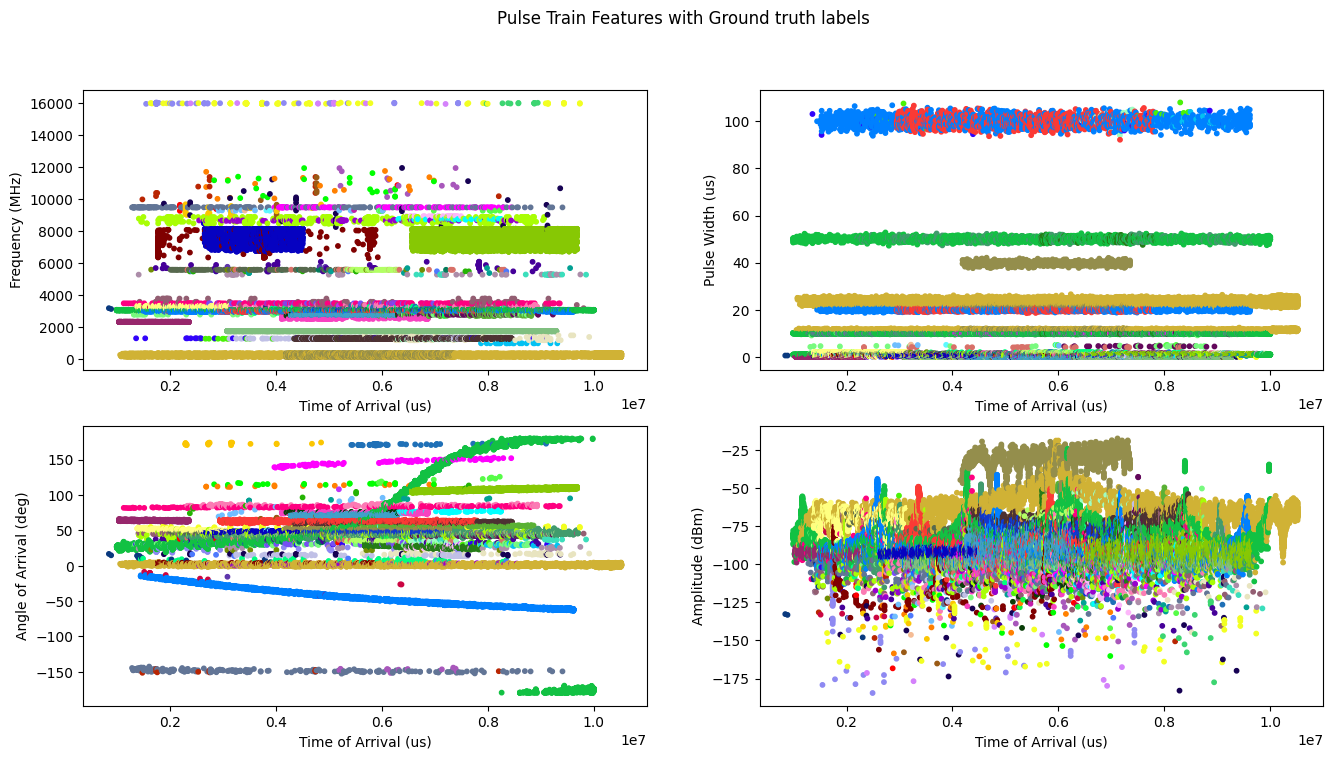

<Figure size 1200x800 with 0 Axes>

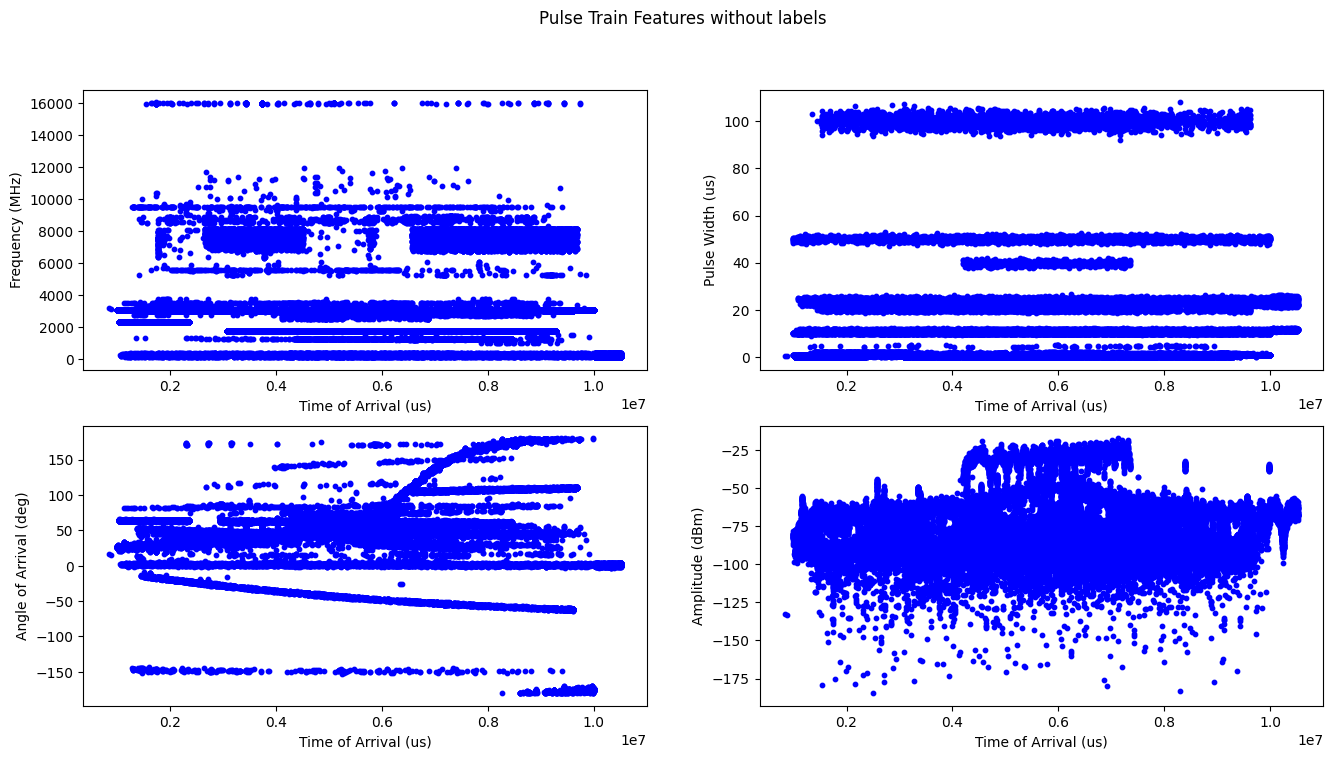

<Figure size 1200x800 with 0 Axes>

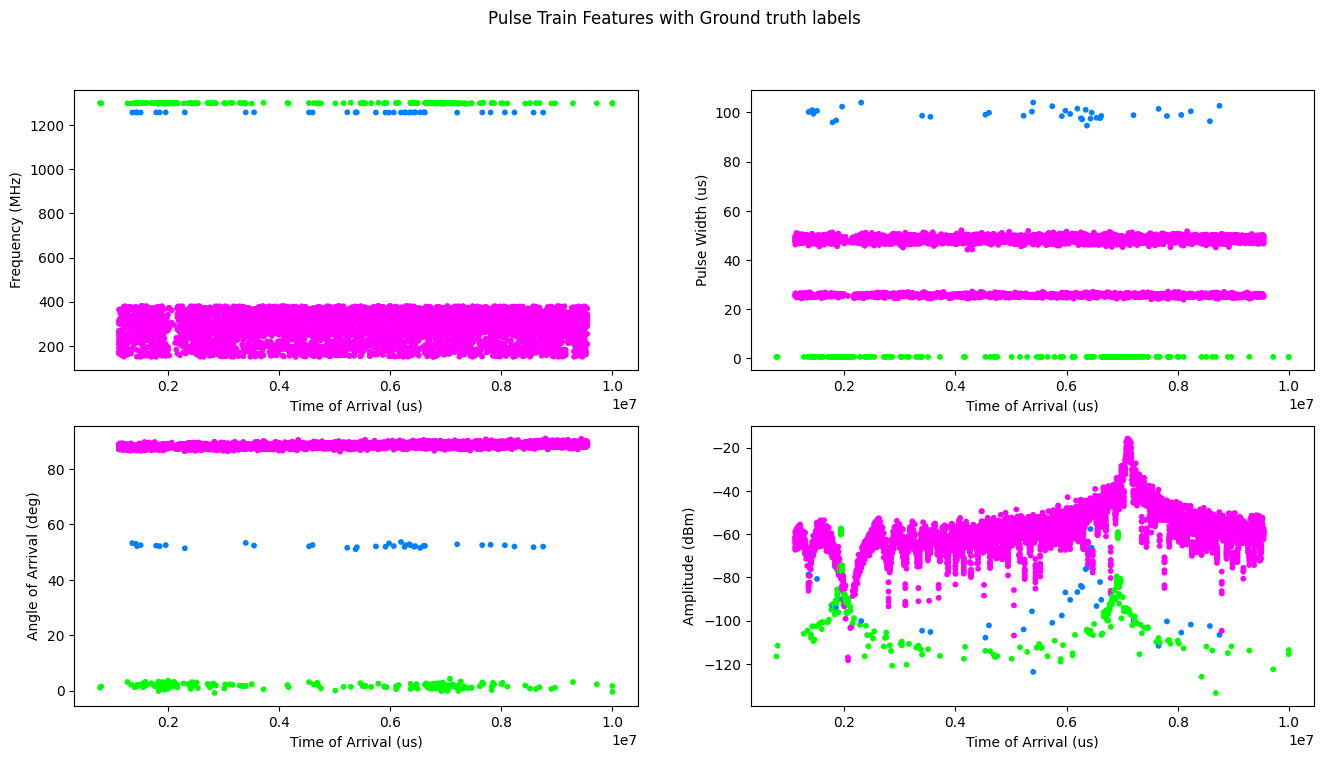

<Figure size 1200x800 with 0 Axes>

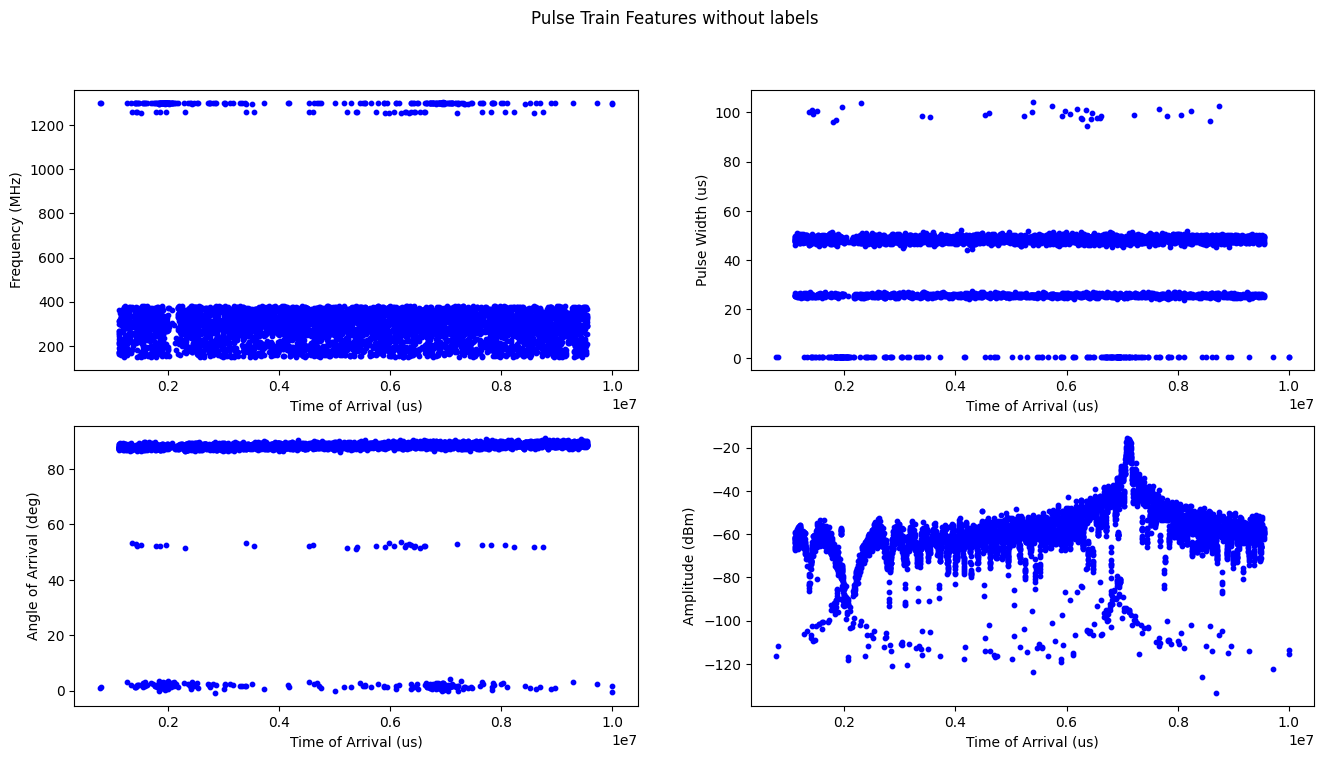

<Figure size 1200x800 with 0 Axes>

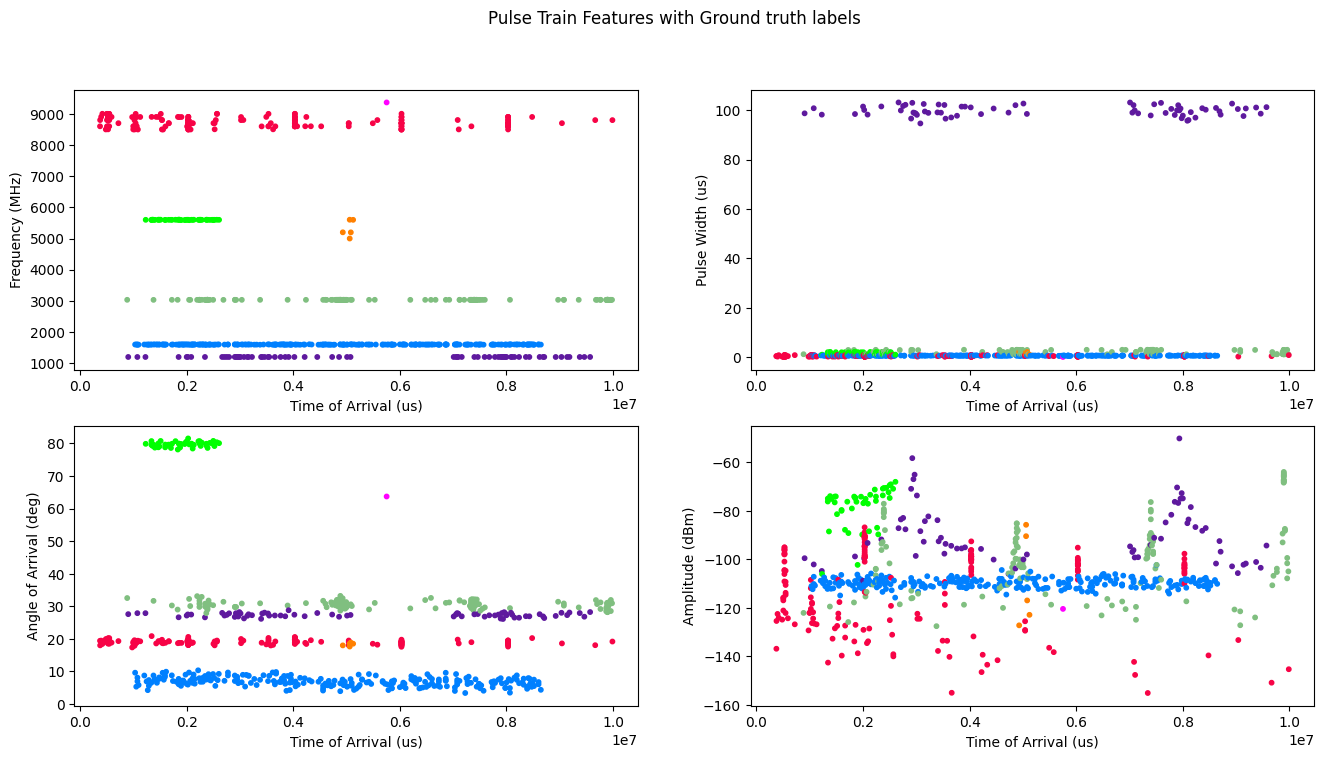

<Figure size 1200x800 with 0 Axes>

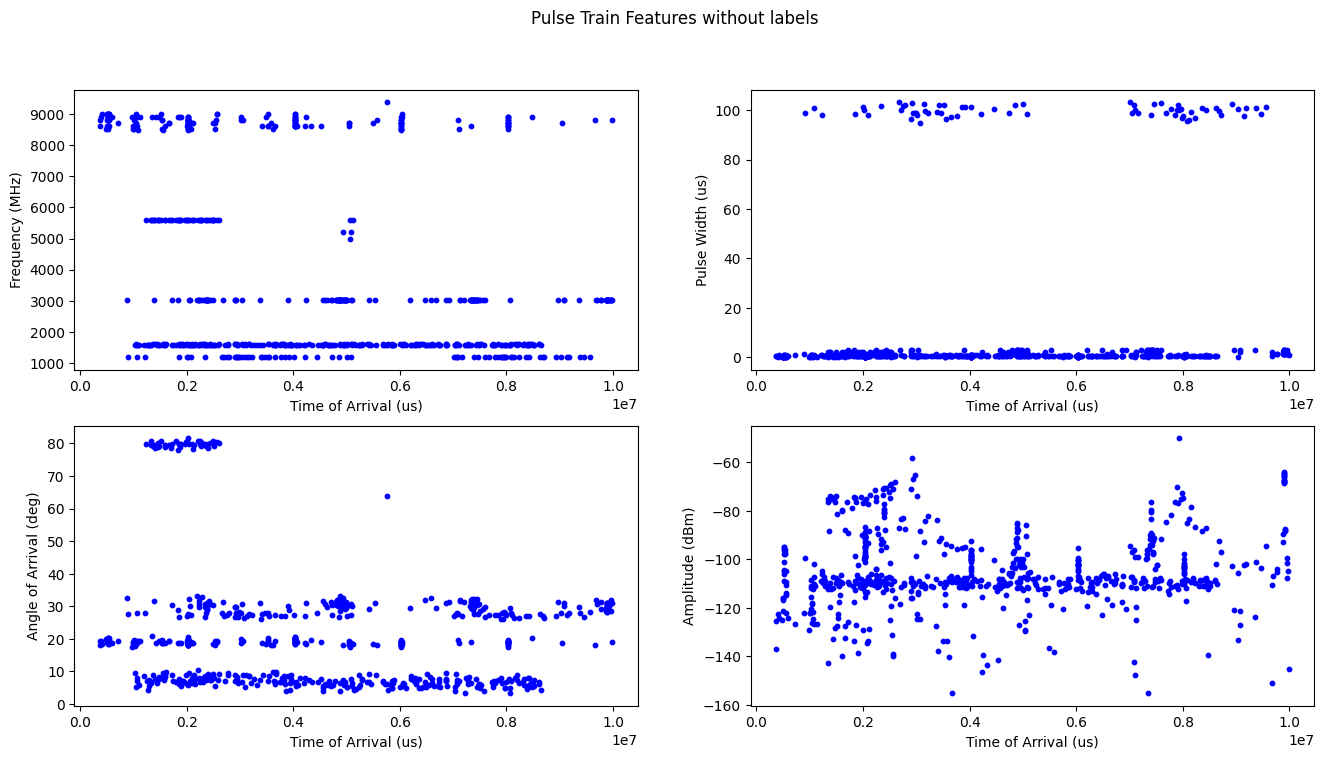

In [8]:
subset_list = ["train", "validation", "test"]

save_dir = Path("../data")
train_set_path = download_dataset(
    save_dir=save_dir,
    subsets=subset_list,
)
train_samples = list((Path(train_set_path) / subset_list[1]).glob("*.h5"))
for sample in train_samples[:3]:
    train_sample = PulseTrain.load(sample)
    plot_pulse_train(train_sample, plot_labels=True) 
    plot_pulse_train(train_sample, plot_labels=False) 



## 3. Process the data 

Next we can prepare our data for training/evaluation, processing the varying length pulse trains into (sub-)pulse trains of length 1000 using ```window_length = 1000```, filtering out any pulse trains with only one emitter using ```mix_emitters = 2```. In our challenge, we suggest using lengths of 1000, but we are very interested in solutions making interesting use of varying lengths. For example, what if a large model trained on very large window lengths generalises to short lengths at test time?

In [ ]:
dataset = DeinterleavingChallengeDataset(
    subset=subset_list[1], window_length=1000, min_emitters=2
) # recall subset_list[1] is "validation""
print(f"Processed dataset length: {len(dataset)}")

Processing files for windows: 100%|██████████| 250/250 [00:04<00:00, 59.32file/s]

processed dataset length: 34715


## 4. Define a DataLoader

Load your ```dataset``` into a ```DataLoader``` as follows - shuffling if necessary and setting a batch size appropriate to your hardware.

In [18]:
dataloader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
)

## 5. Define a deinterleaving model

In our case, we skip training a model (that is the challenge!) defining a model which always predicts the same emitter for every pulse. 

This model inherits the abstract base class ```Deinterleaver```, which enforces that our model takes as input a batch of pulse trains, and outputs a batch sequences of emitter IDs (we need this for simple and equivalent scoring).

Recall in the clustering problem, we're not actually trying to identify which specific emitter that a pulse came from (i.e., the value of the emitter index), just grouping pulses from the same emitter together - so a model always returning the predicted emitter index 1 is equivalent to a model always returning index 0, 2, 3, etc.

In [19]:
class ClumpDeinterleaver(Deinterleaver):

    def __call__(
            self,
            data # Float[Array, "batch_size seq_len feature_len"]
        ):
        return np.ones(data.shape[:2]) # Returning a one for every pulse train

## 6. Evaluate our model on the dataset

We can now use the ```evaluate_model_on_dataset``` function to compute our performance metrics for our deinterleaving model.

 Unsurprisingly, always predicting that a pulse train came from the same single emitter gives a homogeneity of 0 and a completeness of 1. 

Remember - we are evaluating the model on the sub pulse trains, i.e., the windowed data.

In [20]:
scores = evaluate_model_on_dataset(
    dataloader=dataloader,
    model=ClumpDeinterleaver(),
)
for key, value in scores.items():
    print(f"{key}: {value:.4f}")

Evaluating model: 100%|██████████| 34715/34715 [02:12<00:00, 261.16it/s]

Homogeneity: 0.0000
Completeness: 1.0000
V-measure: 0.0000
Adjusted Rand Index: 0.0000
Adjusted Mutual Information: 0.0000


## 7. Visualise results

We can now use our deinterleaver to make some (bad) predictions about what emitter a given pulse belongs to, visualising the results against the ground truth labels.

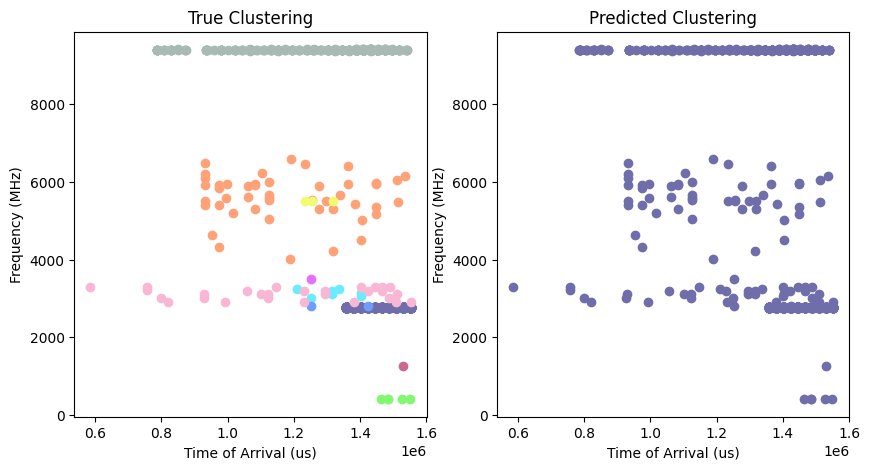

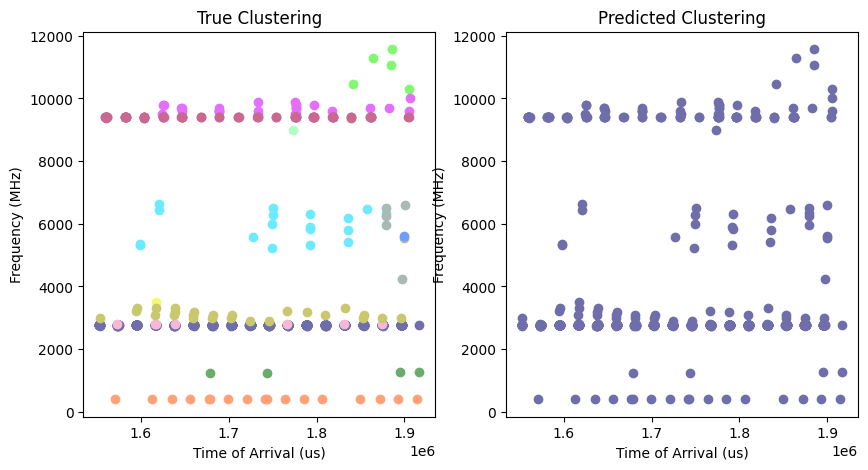

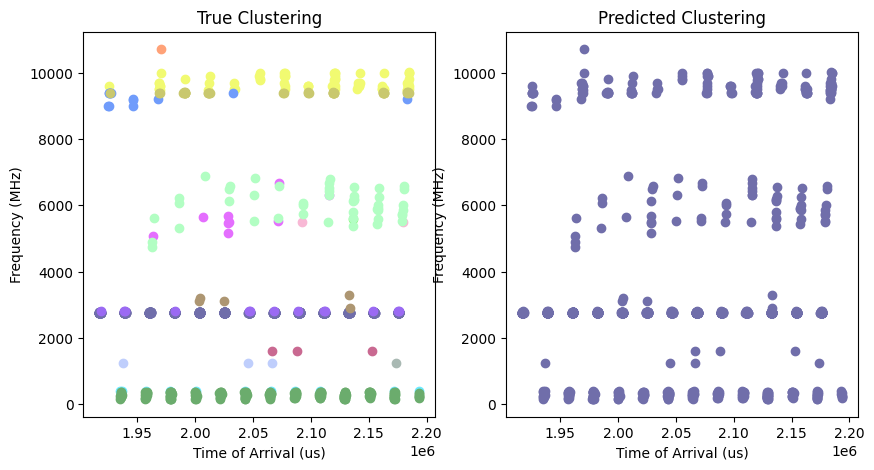

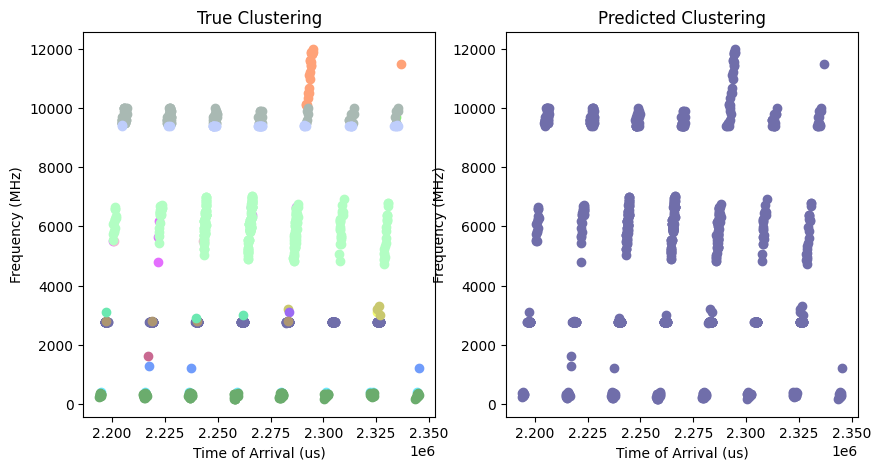

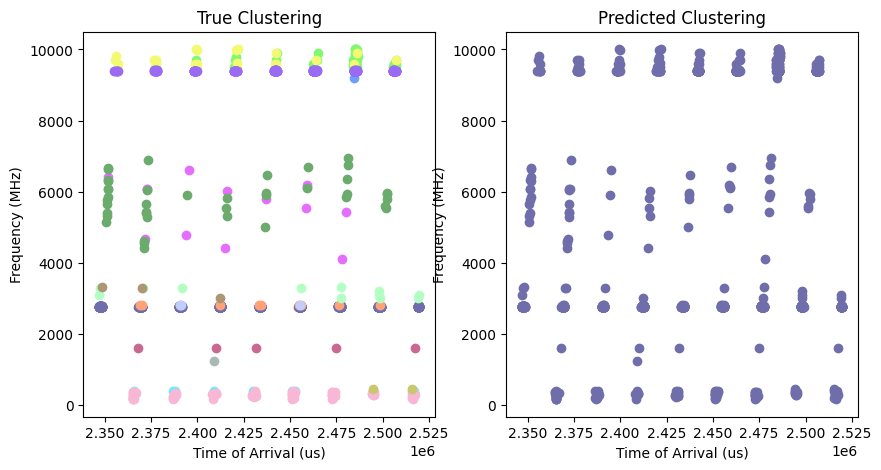

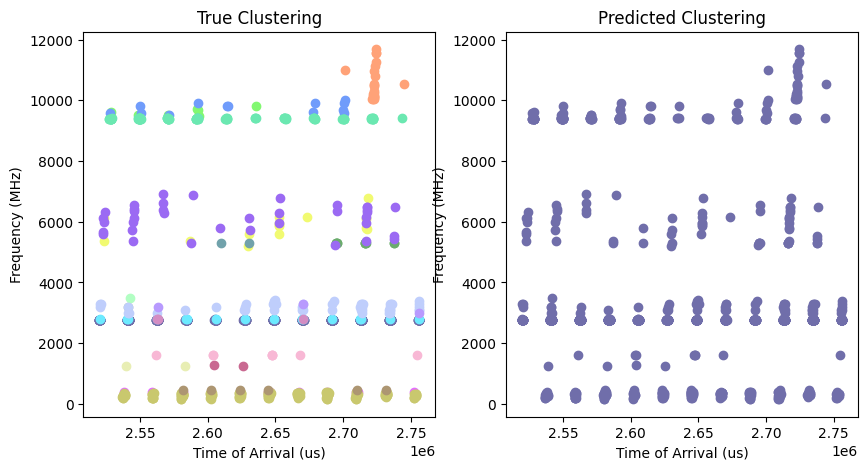

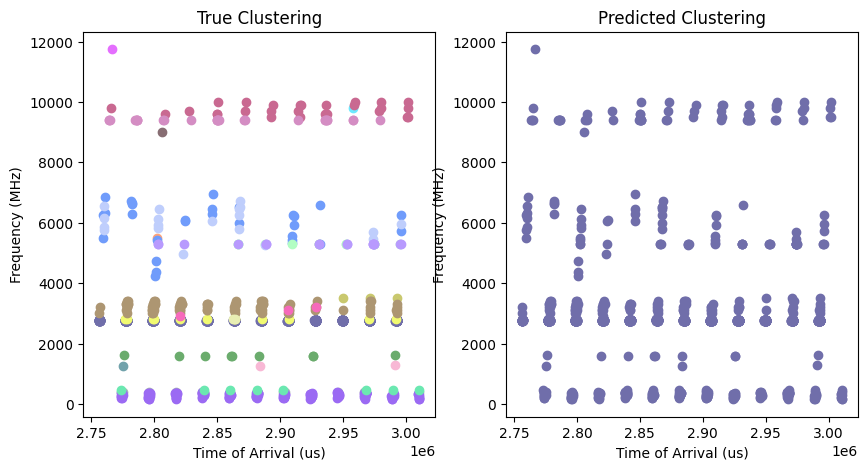

In [21]:
predictions = []
for i, (data, labels) in enumerate(dataloader):
    data = data.numpy()
    prediction = ClumpDeinterleaver()(data)
    predictions.append((data, prediction, labels.numpy()))
    if i > 5:
        break

for data, prediction, labels in predictions:
    plt.figure(figsize=(10, 5))
    plot_true_vs_predicted_features(
        features=data[:2],
        labels_pred=prediction,
        labels_true=labels,
        x_label="Time of Arrival (us)",
        y_label="Frequency (MHz)",
    )
    plt.show()

